In [1]:
import warnings
warnings.simplefilter("ignore", (UserWarning, FutureWarning))

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from tqdm import tqdm

from utils import logger
from utils import data_utils
from utils import metrics
from utils import augmentation as aug
from model import unet
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import time
import argparse
import shutil
import os

In [2]:
"""
Args:
    data_path:
    batch_size:
    num_epochs:

Returns:

"""

data_path = os.path.join(r'D:\GIS\projects\ML_MN_Test\Teststack', 'gridded')
batch_size = 32
start_epoch = 0
num_epochs = 100
learning_rate = 0.0001
momentum = 0.9
print_freq = 4
run = 0

since = time.time()

# get model
model = unet.UNetSmall()

if torch.cuda.is_available():
    model = model.cuda()

# set up binary cross entropy and dice loss
criterion = metrics.BCEDiceLoss()

# optimizer
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# decay LR
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=18, gamma=0.1)

# starting params
best_loss = 999

In [3]:
# get data
dataset_train = data_utils.SatIn(data_path, 'TrainValTest.csv', 'train', transform=transforms.Compose([aug.ToTensorTarget()]))
dataset_val = data_utils.SatIn(data_path, 'TrainValTest.csv', 'valid', transform=transforms.Compose([aug.ToTensorTarget()]))

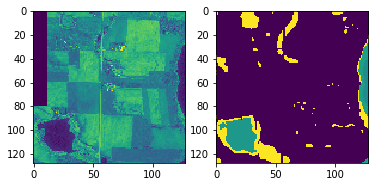

In [4]:
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(dataset_train[1]['sat_img'][1,:,:])
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(dataset_train[1]['map_img'])

torch.Size([128, 128])


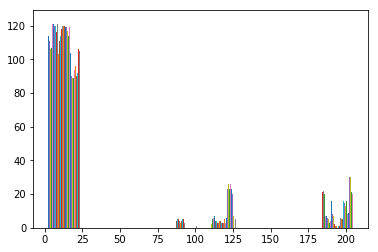

In [5]:
plt.hist(dataset_train[1]['map_img'], bins='auto')
print(dataset_train[1]['map_img'].size())

In [6]:
# creating loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, num_workers=2, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=3, num_workers=2, shuffle=False)

# loggers
#train_logger = logger.Logger('../logs/run_{}/training'.format(str(run)), print_freq)
#val_logger = logger.Logger('../logs/run_{}/validation'.format(str(run)), print_freq)

In [7]:
def train(train_loader, model, criterion, optimizer, scheduler, epoch_num):#, logger, epoch_num):
    """
    Args:
        train_loader:
        model:
        criterion:
        optimizer:
        epoch:
    Returns:
    """
    # logging accuracy and loss
    train_acc = metrics.MetricTracker()
    train_loss = metrics.MetricTracker()

    #log_iter = len(train_loader)//logger.print_freq

    scheduler.step()

    # iterate over data
    for idx, data in enumerate(tqdm(train_loader, desc="training")):

        # get the inputs and wrap in Variable
        if torch.cuda.is_available():
            inputs = Variable(data['sat_img'].cuda())
            labels = Variable(data['map_img'].cuda())
        else:
            inputs = Variable(data['sat_img'])
            labels = Variable(data['map_img'])

        #print(data['sat_img'].shape)
        #print(data['map_img'].shape)
        #print(data['sat_img'][1,1,50:55,50:55])
        #print(data['map_img'][1,50:55,50:55])
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        # prob_map = model(inputs) # last activation was a sigmoid
        # outputs = (prob_map > 0.3).float()
        outputs = model(inputs)
        outputs = torch.nn.functional.sigmoid(outputs)

        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()

        train_acc.update(metrics.dice_coeff(outputs, labels), outputs.size(0))
        train_loss.update(loss.data[0], outputs.size(0))

    print('Training Loss: {:.4f} Acc: {:.4f}'.format(train_loss.avg, train_acc.avg))
    print()

    return {'train_loss': train_loss.avg, 'train_acc': train_acc.avg, 'output': outputs}

In [8]:
def validation(valid_loader, model, criterion, epoch_num):
    """
    Args:
        train_loader:
        model:
        criterion:
        optimizer:
        epoch:
    Returns:
    """
    # logging accuracy and loss
    valid_acc = metrics.MetricTracker()
    valid_loss = metrics.MetricTracker()

    #log_iter = len(valid_loader)//logger.print_freq

    # switch to evaluate mode
    model.eval()

    # Iterate over data.
    for idx, data in enumerate(tqdm(valid_loader, desc='validation')):

        # get the inputs and wrap in Variable
        if torch.cuda.is_available():
            inputs = Variable(data['sat_img'].cuda(), volatile=True)
            labels = Variable(data['map_img'].cuda(), volatile=True)
        else:
            inputs = Variable(data['sat_img'], volatile=True)
            labels = Variable(data['map_img'], volatile=True)

        # forward
        # prob_map = model(inputs) # last activation was a sigmoid
        # outputs = (prob_map > 0.3).float()
        outputs = model(inputs)
        outputs = torch.nn.functional.sigmoid(outputs)

        loss = criterion(outputs, labels)

        valid_acc.update(metrics.dice_coeff(outputs, labels), outputs.size(0))
        valid_loss.update(loss.data[0], outputs.size(0))

    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(valid_loss.avg, valid_acc.avg))
    print()

    return {'valid_loss': valid_loss.avg, 'valid_acc': valid_acc.avg, 'output': outputs}

In [9]:
for epoch in range(start_epoch, num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # step the learning rate scheduler
    lr_scheduler.step()

    # run training and validation
    train_metrics = train(train_dataloader, model, criterion, optimizer, lr_scheduler, epoch)# train_logger, epoch)
    valid_metrics = validation(val_dataloader, model, criterion, epoch)

    # store best loss and save a model checkpoint
    is_best = valid_metrics['valid_loss'] < best_loss
    best_loss = min(valid_metrics['valid_loss'], best_loss)
    '''
    save_checkpoint({
        'epoch': epoch,
        'arch': 'UNetSmall',
        'state_dict': model.state_dict(),
        'best_loss': best_loss,
        'optimizer': optimizer.state_dict()
    }, is_best)
    '''
    cur_elapsed = time.time() - since
    print('Current elapsed time {:.0f}m {:.0f}s'.format(cur_elapsed // 60, cur_elapsed % 60))

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 0/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:03<00:00,  2.28s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 10s
Epoch 1/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.64s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 14s
Epoch 2/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.66s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 18s
Epoch 3/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.67s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 22s
Epoch 4/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.67s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 27s
Epoch 5/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.81s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 31s
Epoch 6/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:03<00:00,  2.12s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 36s
Epoch 7/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.74s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 41s
Epoch 8/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 46s
Epoch 9/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.69s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 50s
Epoch 10/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.69s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 54s
Epoch 11/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.70s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 0m 59s
Epoch 12/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.68s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 3s
Epoch 13/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.76s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 8s
Epoch 14/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.73s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 12s
Epoch 15/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.70s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 17s
Epoch 16/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.82s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 22s
Epoch 17/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 26s
Epoch 18/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.70s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 31s
Epoch 19/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.72s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 35s
Epoch 20/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.70s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 40s
Epoch 21/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.76s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 44s
Epoch 22/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.73s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 49s
Epoch 23/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.75s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 53s
Epoch 24/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.69s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 1m 58s
Epoch 25/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.73s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 2s
Epoch 26/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.78s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 7s
Epoch 27/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.71s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 11s
Epoch 28/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 16s
Epoch 29/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.70s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 20s
Epoch 30/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.73s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 25s
Epoch 31/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.74s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 29s
Epoch 32/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.78s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 34s
Epoch 33/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.75s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 39s
Epoch 34/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.67s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 43s
Epoch 35/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.71s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 47s
Epoch 36/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 52s
Epoch 37/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.74s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 2m 57s
Epoch 38/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.70s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 1s
Epoch 39/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.71s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 5s
Epoch 40/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.71s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 10s
Epoch 41/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.72s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 14s
Epoch 42/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.75s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 19s
Epoch 43/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.69s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 23s
Epoch 44/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.80s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 28s
Epoch 45/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.74s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 33s
Epoch 46/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.86s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 37s
Epoch 47/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.76s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.60it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 42s
Epoch 48/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.80s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 47s
Epoch 49/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.89s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 51s
Epoch 50/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.79s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 3m 56s
Epoch 51/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.80s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 1s
Epoch 52/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.73s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 5s
Epoch 53/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.73s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 10s
Epoch 54/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.72s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 14s
Epoch 55/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 19s
Epoch 56/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.76s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 23s
Epoch 57/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.76s/it]


Training Loss: 1046.7445 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.60it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 28s
Epoch 58/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 32s
Epoch 59/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 37s
Epoch 60/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.81s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.59it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 42s
Epoch 61/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.76s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.59it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 46s
Epoch 62/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.74s/it]


Training Loss: 1046.7445 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 51s
Epoch 63/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.81s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.59it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 4m 56s
Epoch 64/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.83s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 0s
Epoch 65/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.80s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 5s
Epoch 66/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.78s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 10s
Epoch 67/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 14s
Epoch 68/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.88s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 19s
Epoch 69/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.80s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 24s
Epoch 70/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 28s
Epoch 71/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.74s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 33s
Epoch 72/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.80s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.60it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 38s
Epoch 73/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.79s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 42s
Epoch 74/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.84s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 47s
Epoch 75/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.82s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 52s
Epoch 76/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.86s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 5m 57s
Epoch 77/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.90s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.53it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 2s
Epoch 78/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.87s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.42it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 7s
Epoch 79/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.86s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 12s
Epoch 80/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.91s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.50it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 17s
Epoch 81/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.88s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.53it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 22s
Epoch 82/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.90s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 27s
Epoch 83/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.85s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.53it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 31s
Epoch 84/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.83s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 36s
Epoch 85/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.80s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 41s
Epoch 86/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.93s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.50it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 46s
Epoch 87/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.90s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 51s
Epoch 88/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.90s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.49it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 6m 56s
Epoch 89/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.90s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.50it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 1s
Epoch 90/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.92s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.49it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 6s
Epoch 91/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.93s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.44it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 11s
Epoch 92/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.90s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.50it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 16s
Epoch 93/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.93s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.51it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 21s
Epoch 94/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.85s/it]


Training Loss: 1046.7443 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 26s
Epoch 95/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.81s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 30s
Epoch 96/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.85s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 35s
Epoch 97/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.78s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 40s
Epoch 98/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.81s/it]


Training Loss: 1046.7444 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 45s
Epoch 99/99
----------


training: 100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.77s/it]


Training Loss: 1046.7445 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Validation Loss: 693.5661 Acc: 0.0000

Current elapsed time 7m 49s
Training complete in 7m 49s


In [48]:
train_metrics['output'].shape

torch.Size([15, 1, 128, 128])

In [67]:
dataset_test = data_utils.SatIn(data_path, 'TrainValTest.csv', 'test', transform=transforms.Compose([aug.ToTensorTarget()]))
test_dataloader = DataLoader(dataset_test, batch_size=3, num_workers=2, shuffle=False)
for epoch in range(start_epoch, num_epochs):
    validation(test_dataloader, model, criterion, epoch)


validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.87it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.86it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.88it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


Validation Loss: 1088.2841 Acc: 0.0000



validation:   0%|                                                    | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 